In [43]:
import pandas as pd
import numpy as np

def read_LINEAR_period():
    """
    Read the LINEAR_period.dat file and return a dataframe with the data.

    Returns:
    - df (pandas.DataFrame): Dataframe containing the data from LINEAR_period.dat.
    """
    # Read the file line by line
    with open('data/LINEAR_period.dat', 'r') as file:
        lines = file.readlines()

    # Split the first line to get column names
    column_names = lines[0].strip().split()

    # Split the remaining lines and create a list of lists
    data = [line.strip().split() for line in lines[1:]]

    # Create the dataframe
    df = pd.DataFrame(data, columns=column_names)

    return df


def read_LINEAR_params():
    """
    Read the LINEAR_params.dat file and return a dataframe with the parameters.
    
    Returns:
    - df (pandas.DataFrame): Dataframe containing the parameters from LINEAR_params.dat.
    """
    # Read the file line by line
    with open('data/LINEAR_params.dat', 'r') as file:
        lines = file.readlines()

    # Split the first line to get column names
    column_names = lines[0].strip().split()

    # Split the remaining lines and create a list of dictionaries
    data = [dict(zip(column_names, line.strip().split())) for line in lines[1:]]

    # Convert data types
    for row in data:
        for i in range(11):
            row[column_names[i]] = float(row[column_names[i]])
        for i in range(11, 14):
            row[column_names[i]] = int(row[column_names[i]])

   
    # Create the dataframe
    df = pd.DataFrame(data)

    df['LINEARobjectID'] = df['LINEARobjectID'].astype(str)    

    return df

def read_dat_file(id):
    """
    Read a .dat file containing time, brightness, and error data for a variable star.

    Parameters:
    id (str): The ID of the variable star.

    Returns:
    pandas.DataFrame: A DataFrame containing the data from the .dat file.
    """
    file_path = f'data/LINEAR_light_curves/{id}.dat'
    column_names = ['time', 'brightness', 'error']
    data = []

    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process each line and extract the values
    for line in lines:
        values = line.strip().split()
        values = [float(value) for value in values]
        data.append(values)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data, columns=column_names)

    # Change datatype of 'LINEARobjectID' to string
    df['delta_time'] = df['time'].diff()
    df['delta_time'].iloc[0] = 0
    
    return df

params_df = read_LINEAR_params()
params_df

# Merge params_df with period_df
period_df = read_LINEAR_period()
period_df['LINEARobjectID'] = period_df['LINEARobjectID'].astype(str)
merged_df = params_df.merge(period_df, on='LINEARobjectID')

# Discard any NaN values
merged_df = merged_df.dropna()

# Reduce merged_df to LINEARobjectID, P, LCtype_x
merged_df = merged_df[['LINEARobjectID', 'P', 'LCtype_x']]

# Rename LCtype_x to LCtype and convert it to a int
merged_df = merged_df.rename(columns={'LCtype_x': 'LCtype'})
merged_df['LCtype'] = merged_df['LCtype'].astype(int)

# Change P to float
merged_df['P'] = merged_df['P'].astype(float)
merged_df

,LINEARobjectID,P,LCtype
0,29848,0.557009,1
1,32086,0.569258,1
2,43542,0.245818,1
3,50402,0.643293,1
4,61011,0.662369,1
...,...,...,...
6141,24209652,1.490753,5
6142,24211479,0.340653,5
6143,24215207,0.763200,4
6144,24264418,0.296639,5


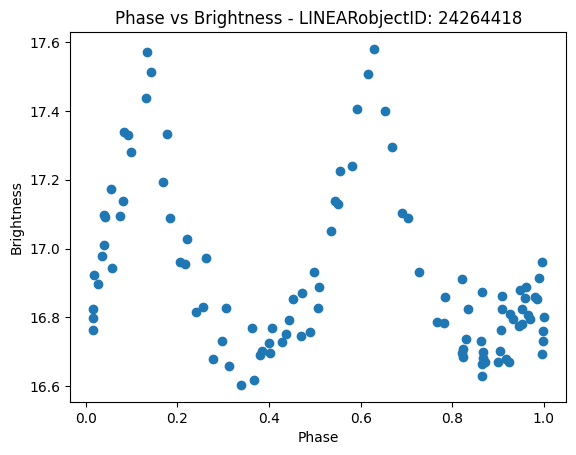

In [52]:
# Call read_dat_file(24264418) to get the dataframe
number = 24264418
import matplotlib.pyplot as plt

def create_phase_dataframe(number):
    """
    Create a dataframe with phase instead of time for a given LINEARobjectID.

    Parameters:
    - number (int): The LINEARobjectID.

    Returns:
    - df (pandas.DataFrame): Dataframe containing the phase data.
    """
    df = read_dat_file(number)

    # Get the period for the corresponding LINEARobjectID
    period = merged_df.loc[merged_df['LINEARobjectID'] == str(number), 'P'].values[0]

    # Convert time to phase
    df['phase'] = (df['time'] % period) / period

    # Add delta_phase column
    df['delta_phase'] = df['phase'].diff()

    # Set first delta_phase value to 0
    df['delta_phase'].iloc[0] = 0

    return df

# Call create_phase_dataframe(24264418) to get the dataframe with phase
df_phase = create_phase_dataframe(24264418)

# Plot the scatter plot of phase vs brightness
plt.scatter(df_phase['phase'], df_phase['brightness'])
plt.xlabel('Phase')
plt.ylabel('Brightness')
plt.title(f'Phase vs Brightness - LINEARobjectID: {str(number)}')

# Display the plot
plt.show()

In [53]:
df_phase

,time,brightness,error,delta_time,phase,delta_phase
0,52709.309034,16.726,0.083,0.000000,0.399145,0.000000
1,52709.322383,16.793,0.087,0.013349,0.444146,0.045001
2,52709.336038,16.759,0.083,0.013655,0.490178,0.046032
3,52709.349559,17.050,0.109,0.013521,0.535759,0.045581
4,52709.363087,17.241,0.130,0.013528,0.581363,0.045604
...,...,...,...,...,...,...
99,54570.189911,17.507,0.189,37.817299,0.616345,0.485931
100,54570.200960,17.400,0.165,0.011049,0.653592,0.037247
101,54570.212041,17.102,0.126,0.011081,0.690948,0.037355
102,54570.223120,16.931,0.109,0.011079,0.728296,0.037348


In [54]:
import numpy as np

# Create an empty list to store the 2D numpy arrays
result = []
label = []

LCtype = merged_df['LCtype'].values

# Iterate over the rows of merged_df
for index, row in merged_df.iterrows():

    # Extract the LINEARobjectID
    LINEARobjectID = row['LINEARobjectID']

    # Print the progress every 100 rows
    if index % 100 == 0:
        print(f'{index/len(merged_df)*100: .2f} %')
    
    # Call create_phase_dataframe() to get the dataframe with phase
    df_phase = create_phase_dataframe(LINEARobjectID)
    
    # Extract the delta_phase and brightness columns
    data = df_phase[['delta_phase', 'brightness']].values
    
    # Select the first 200 rows
    if len(data) < 201:
        continue

    data = data[1:201]
    
    # Append the 2D numpy array to the result list
    result.append(data)
    label.append(LCtype[index])

# Convert the list of 2D numpy arrays to a 3D numpy array
result = np.stack(result)
label = np.array(label)

# Print the shape of the resulting 3D numpy array
print(result.shape)
print(label.shape)


 0.00 %
 1.63 %
 3.25 %
 4.88 %
 6.51 %
 8.14 %
 9.76 %
 11.39 %
 13.02 %
 14.64 %
 16.27 %
 17.90 %
 19.52 %
 21.15 %
 22.78 %
 24.41 %
 26.03 %
 27.66 %
 29.29 %
 30.91 %
 32.54 %
 34.17 %
 35.80 %
 37.42 %
 39.05 %
 40.68 %
 42.30 %
 43.93 %
 45.56 %
 47.19 %
 48.81 %
 50.44 %
 52.07 %
 53.69 %
 55.32 %
 56.95 %
 58.57 %
 60.20 %
 61.83 %
 63.46 %
 65.08 %
 66.71 %
 68.34 %
 69.96 %
 71.59 %
 73.22 %
 74.85 %
 76.47 %
 78.10 %
 79.73 %
 81.35 %
 82.98 %
 84.61 %
 86.23 %
 87.86 %
 89.49 %
 91.12 %
 92.74 %
 94.37 %
 96.00 %
 97.62 %
 99.25 %
(4233, 200, 2)
(4233,)


In [55]:
import pickle

# Define the file path
file_path = 'data/lightcurve_data.pkl'

# Save the results as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(result, file)

# Define the file path
file_path = 'data/lightcurve_label.pkl'

# Save the results as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(label, file)

In [2]:
import pickle

# Define the file paths
result_file_path = 'data/lightcurve_data.pkl'
label_file_path = 'data/lightcurve_label.pkl'

# Load the result from the pickle file
with open(result_file_path, 'rb') as file:
    result = pickle.load(file)

# Load the label from the pickle file
with open(label_file_path, 'rb') as file:
    label = pickle.load(file)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate
import tensorflow as tf

# Define the input shape
input_shape = (200, 2)  # Arbitrary length sequence with 2 values

# Define the encoder
encoder_input = Input(shape=input_shape)
encoder_gru1 = Bidirectional(GRU(64, return_sequences=True))(encoder_input)
encoder_gru1 = layers.Dropout(0.25)(encoder_gru1)
encoder_gru2 = Bidirectional(GRU(64, return_sequences=True))(encoder_gru1)
encoder_gru2 = layers.Dropout(0.25)(encoder_gru2)
encoder_linear = Dense(8)(encoder_gru2)

# Take the last element of encoder_linear
encoder_embedding = encoder_linear[:, -1, :]

# Copy the encoder embedding as many times as the length of input sequence
decoder_input = RepeatVector(encoder_input.shape[1])(encoder_embedding)
d_time = tf.reshape(encoder_input[:, :, 0], (-1, input_shape[0], 1))

# Concatenate the encoder embedding with first value of input sequence
decoder_input = Concatenate(axis=-1)([decoder_input, d_time])

# Reconstructed measurement value
decoder_gru1 = Bidirectional(GRU(64, return_sequences=True))(decoder_input)
decoder_gru1 = layers.Dropout(0.25)(decoder_gru1)
decoder_gru2 = Bidirectional(GRU(64, return_sequences=True))(decoder_gru1)
decoder_gru2 = layers.Dropout(0.25)(decoder_gru2)
decoder_output = Dense(1)(decoder_gru2)

# Create the autoencoder model
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model with weighted mean squared error loss function
weights_input = Input(shape=(None, 1))  # Weights for loss function
autoencoder.compile(optimizer='adam', loss='mse', sample_weight_mode='temporal', metrics=['mae'])

# summary
autoencoder.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 2)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 200, 128)             26112     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 200, 128)             0         ['bidirectional[0][0]']       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 200, 128)             74496     ['dropout[0][0]']      

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(result, label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Normalize the training, validation, and test data
X_train_mean = X_train.mean(axis=1, keepdims=True)
X_train_std = X_train.std(axis=1, keepdims=True)
X_train = (X_train - X_train_mean) / X_train_std

X_val_mean = X_val.mean(axis=1, keepdims=True)
X_val_std = X_val.std(axis=1, keepdims=True)
X_val = (X_val - X_val_mean) / X_val_std

X_test_mean = X_test.mean(axis=1, keepdims=True)
X_test_std = X_test.std(axis=1, keepdims=True)
X_test = (X_test - X_test_mean) / X_test_std

In [5]:
# Fit the autoencoder model to the training data with the mean squared error callback
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=10, batch_size=32)

# Evaluate the model using the validation data
loss = autoencoder.evaluate(X_val, X_val)
print("Validation loss:", loss)

Epoch 1/10


106/106 [==============================] - 77s 580ms/step - loss: 0.7702 - mae: 0.5515 - val_loss: 0.7481 - val_mae: 0.5450
Epoch 2/10
106/106 [==============================] - 58s 550ms/step - loss: 0.7522 - mae: 0.5437 - val_loss: 0.7469 - val_mae: 0.5420
Epoch 3/10
106/106 [==============================] - 57s 539ms/step - loss: 0.7501 - mae: 0.5428 - val_loss: 0.7440 - val_mae: 0.5443
Epoch 4/10
106/106 [==============================] - 57s 539ms/step - loss: 0.7484 - mae: 0.5423 - val_loss: 0.7431 - val_mae: 0.5395
Epoch 5/10
106/106 [==============================] - 57s 541ms/step - loss: 0.7474 - mae: 0.5420 - val_loss: 0.7425 - val_mae: 0.5431
Epoch 6/10
106/106 [==============================] - 61s 575ms/step - loss: 0.7466 - mae: 0.5416 - val_loss: 0.7404 - val_mae: 0.5363
Epoch 7/10
106/106 [==============================] - 59s 557ms/step - loss: 0.7446 - mae: 0.5416 - val_loss: 0.7397 - val_mae: 0.5399
Epoch 8/10
106/106 [==============================] -

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

encoder = Model(inputs=encoder_input, outputs=encoder_embedding)

# Use the encoder model to encode the training data, validation data, test data
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

# Train a random forest classifier on the encoded training data

# Perform a randomized search over the 'n_estimators' and 'max_depth' hyperparameters
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
rfc = RandomForestClassifier(random_state=42)
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)
rfc_cv.fit(X_train_encoded, y_train)

# Print the optimal hyperparameters
print("Optimal n_estimators:", rfc_cv.best_params_['n_estimators'])
print("Optimal max_depth:", rfc_cv.best_params_['max_depth'])

# Test on the encoded test data
print("Test accuracy:", rfc_cv.score(X_test_encoded, y_test))


14/14 [==============================] - 1s 51ms/step
Optimal n_estimators: 100
Optimal max_depth: 10
Test accuracy: 0.4834905660377358


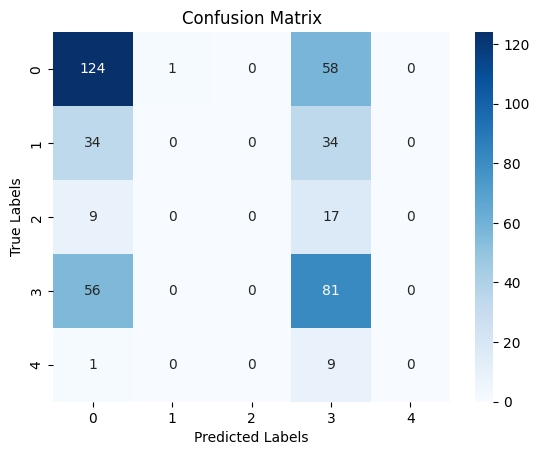

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels for the test data
y_pred = rfc_cv.predict(X_test_encoded)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()
